# Injuries and EDA
The notebook is named 'EDA,' but it also will fetch the injury report from the api and filter injured players from the dataset. We also will have the option to manually remove players is their injury status is uncertain. The mins_proj and mins_share variables will be adjusted to account for the removed players.<br>

Then, finally, we will get summary statistics and histograms to check if our data makes sense.<br>

**If we need to adjust player availability, like putting a player back in the list who we took out before, we have to run this notebook again from the top and then run predictions.**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import requests
import sqlite3
import re
import matplotlib.pyplot as plt

# Get the parent directory where config.py is located
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

API_KEY = None
API_HOST = None

In [2]:
from config import API_KEY, API_HOST

headers = {
    "x-rapidapi-key": API_KEY,
    "x-rapidapi-host": API_HOST
}

In [3]:
today = (datetime.now()).strftime('%Y%m%d')

In [4]:
main_df = pd.read_csv('ready_for_injuries.csv')

In [5]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250210_GS@MIL,28006619932,17,MIL,ATL,10.000000,1.866667,1.733333,4.400000,...,32.133333,24.120487,5900,2025-02-10,C,False,False,False,False,True
1,Dejounte Murray,20250210_NO@OKC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.487002,3500,2025-02-10,PG,True,False,False,False,False
2,Shake Milton,20250210_UTA@LAL,28008397499,14,LAL,ORL,3.600000,2.266667,0.666667,1.800000,...,14.200000,9.417833,3700,2025-02-10,SG,True,False,False,False,False
3,Gary Trent Jr.,20250210_GS@MIL,28038899869,17,MIL,GS,9.066667,1.666667,3.000000,4.133333,...,25.466667,19.116237,4200,2025-02-10,SG,False,True,True,False,False
4,Gary Payton II,20250210_GS@MIL,28038983399,10,GS,IND,4.333333,1.400000,0.400000,2.333333,...,14.000000,11.332027,3700,2025-02-10,PG,True,True,False,False,False


In [6]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    344 non-null    object 
 1   game_id     344 non-null    object 
 2   player_id   344 non-null    int64  
 3   team_id     344 non-null    int64  
 4   team        344 non-null    object 
 5   teamAbv     344 non-null    object 
 6   fga         344 non-null    float64
 7   ast         344 non-null    float64
 8   tptfgm      344 non-null    float64
 9   fgm         344 non-null    float64
 10  fta         344 non-null    float64
 11  tptfga      344 non-null    float64
 12  OffReb      344 non-null    float64
 13  ftm         344 non-null    float64
 14  blk         344 non-null    float64
 15  DefReb      344 non-null    float64
 16  plusMinus   344 non-null    float64
 17  stl         344 non-null    float64
 18  pts         344 non-null    float64
 19  fouls       344 non-null    f

In [7]:
#Changing player_id to string
main_df["player_id"] = main_df["player_id"].astype(str)

In [8]:
main_df['player_id'].nunique()

344

In [9]:
#Remove teams that aren't in slate
#There's nothing programmatic about this. We just check the full NBA schedule against the FD or DK slate we're playing.
teams_to_remove = []
remove_teams = int(input("How many teams do you want to remove from the slate?"))
for i in range(0, remove_teams):
    teams_to_remove.append(input("Remove team."))

How many teams do you want to remove from the slate? 0


In [10]:
main_df = main_df[~main_df['team'].isin(teams_to_remove)]

In [11]:
player_ids = list(main_df['player_id'])

# Getting injury reports
We call the API to get injury information and availability status of every player in the current day's slate.

In [12]:
col_heads = ['name', 'player_id', 'injury', 'inj_date', 'status', 'return_date', 'last_game']
rows = []
for id in player_ids:
    
    url = f"https://tank01-fantasy-stats.p.rapidapi.com/getNBAPlayerInfo?playerID={id}"
        
    headers = {
        "x-rapidapi-key": "3103a75392msh7bce7c32fde122cp134393jsn4d42ed6d08a8",
        "x-rapidapi-host": "tank01-fantasy-stats.p.rapidapi.com"
    }
    
    response = requests.get(url, headers=headers)
    result = response.json()
    
    if 'body' in result and result['body']:  
        injury_data = result['body'].get('injury', {})
        if any(value != '' for value in injury_data.values()):  # Check if injury dict has data
            rows.append([
                result['body']['longName'],
                result['body']['playerID'],
                injury_data.get('description', ''),
                injury_data.get('injDate', ''),
                injury_data.get('designation', ''),
                injury_data.get('injReturnDate', ''),
                result['body'].get('lastGamePlayed', '')
            ])

injury_df = pd.DataFrame(rows, columns = col_heads)

In [13]:
injury_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
1,Stephen Curry,28046691632,Feb 9: Curry is questionable for Monday's game...,,Day-To-Day,20250210,20250208_GS@CHI
2,Matisse Thybulle,28108517499,Feb 9: Thybulle (ankle) has been ruled out for...,20240805,Out,20250212,20240329_POR@MIA
3,Russell Westbrook,28116619932,Feb 3: Head coach Mike Malone said Monday that...,,Out,20250220,20250131_DEN@PHI
4,Giannis Antetokounmpo,28118035349,"Feb 9: Antetokounmpo, who's already missed fou...",,Out,20250220,20250202_MEM@MIL
...,...,...,...,...,...,...,...
125,Jesse Edwards,94924452027,Feb 7: Edwards (ankle) isn't on the injury rep...,,Out,20250212,
126,Taylor Hendricks,949347211869,Nov 6: Hendricks underwent surgery on his brok...,20240805,Out,20251001,20241028_UTA@DAL
127,Alex Sarr,949541715989,Feb 9: Sarr (ankle) has been ruled out for Mon...,,Out,20250212,20250127_WAS@DAL
128,Brice Sensabaugh,949747621869,,20240805,,,20250208_UTA@LAC


In [14]:
len(injury_df)

130

In [15]:
#Filtering injury_df for players who are out.
out_df = injury_df[injury_df['status'] == 'Out']

In [16]:
out_players = list(out_df['player_id'])

In [17]:
#Starting a dataframe of players who aren't playing and can't be used in lineups
removed_df = main_df[main_df['player_id'].isin(out_players)]

In [18]:
#Taking those players out of main_df
main_df = main_df[~main_df['player_id'].isin(out_players)]

In [19]:
removed_df

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
1,Dejounte Murray,20250210_NO@OKC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.487002,3500,2025-02-10,PG,True,False,False,False,False
17,Matisse Thybulle,20250210_POR@DEN,28108517499,25,POR,PHO,5.066667,1.733333,0.933333,1.933333,...,21.333333,15.064731,3500,2025-02-10,SF,False,False,True,False,False
18,Russell Westbrook,20250210_POR@DEN,28116619932,8,DEN,LAC,11.266667,5.800000,1.266667,5.800000,...,30.133333,23.755478,6000,2025-02-10,PG,True,False,False,False,False
19,Giannis Antetokounmpo,20250210_GS@MIL,28118035349,17,MIL,SAC,20.800000,5.666667,0.133333,12.733333,...,34.666667,26.022102,11800,2025-02-10,PF,False,False,False,True,False
21,Torrey Craig,20250210_BOS@MIA,28118432369,2,BOS,MIN,4.333333,0.733333,1.400000,2.066667,...,13.733333,10.687997,3700,2025-02-10,SF,False,False,True,False,False
22,Collin Sexton,20250210_UTA@LAL,28118882869,29,UTA,UTA,14.866667,4.733333,1.866667,6.933333,...,28.933333,17.320068,6100,2025-02-10,SG,True,True,False,False,False
28,Maxi Kleber,20250210_UTA@LAL,28148908169,14,LAL,IND,3.600000,2.066667,0.533333,1.333333,...,20.266667,13.441415,3500,2025-02-10,C,False,False,False,True,True
33,Dean Wade,20250210_MIN@CLE,28178359499,6,CLE,IND,5.133333,1.866667,1.533333,2.333333,...,24.133333,18.597338,3700,2025-02-10,PF,False,False,True,True,False
34,Kelly Olynyk,20250210_NO@OKC,28188235349,19,NO,MIA,4.400000,2.200000,0.666667,2.466667,...,15.600000,10.265436,4700,2025-02-10,PF,False,False,False,True,True
36,Vlatko Cancar,20250210_POR@DEN,28188530069,8,DEN,NO,1.750000,0.000000,0.250000,1.000000,...,8.500000,6.700937,3500,2025-02-10,SF,False,False,True,False,False


In [20]:
len(main_df)

292

In [21]:
out_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
2,Matisse Thybulle,28108517499,Feb 9: Thybulle (ankle) has been ruled out for...,20240805,Out,20250212,20240329_POR@MIA
3,Russell Westbrook,28116619932,Feb 3: Head coach Mike Malone said Monday that...,,Out,20250220,20250131_DEN@PHI
4,Giannis Antetokounmpo,28118035349,"Feb 9: Antetokounmpo, who's already missed fou...",,Out,20250220,20250202_MEM@MIL
5,Torrey Craig,28118432369,Feb 9: Craig (ankle) has been ruled out for Mo...,,Out,20250212,20241230_CHI@CHA
6,Collin Sexton,28118882869,Feb 4: The Jazz announced Tuesday that Sexton ...,20240805,Out,20250212,20250203_IND@UTA
9,Maxi Kleber,28148908169,Feb 4: Kleber will have his surgically repaire...,,Out,20250411,20250125_BOS@DAL
11,Dean Wade,28178359499,Jan 28: Wade was diagnosed with a bone bruise ...,,Out,20250220,20250124_CLE@PHI
12,Kelly Olynyk,28188235349,Feb 9: Olynyk (recently traded) is out for Mon...,,Out,20250212,20250205_MEM@TOR
13,Vlatko Cancar,28188530069,Dec 4: Cancar (knee) will be re-evaluated in 8...,,Out,20250220,20241119_DEN@MEM


In [22]:
#Starting a game-time-decision dataframe
gtd_df = injury_df[injury_df['status'] == 'Day-To-Day'].reset_index(drop = True)

In [23]:
len(gtd_df)

32

In [24]:
gtd_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Stephen Curry,28046691632,Feb 9: Curry is questionable for Monday's game...,,Day-To-Day,20250210,20250208_GS@CHI
1,Jaylen Brown,28138379499,Feb 9: Brown (knee) is questionable for Monday...,,Day-To-Day,20250210,20250208_BOS@NY
2,Mike Conley,28236562792,Feb 9: Conley (finger) is questionable for Mon...,,Day-To-Day,20250210,20250206_HOU@MIN
3,Austin Reaves,28268636399,Feb 9: Reaves is probable for Monday's game ag...,,Day-To-Day,20250210,20250208_IND@LAL
4,Justin Minaya,28408827869,Feb 8: Minaya (ankle) has been removed from th...,,Day-To-Day,20250210,20250123_POR@ORL
5,Dante Exum,28478111729,Feb 9: Exum is (Achilles) listed as questionab...,,Day-To-Day,20250210,20250208_HOU@DAL
6,D'Angelo Russell,28478359129,Feb 9: Russell is questionable for Monday's ga...,,Day-To-Day,20250210,20250207_MIA@BKN
7,Robert Williams III,28508516399,Feb 9: Williams (knee) is questionable for Mon...,20240805,Day-To-Day,20250210,20250208_POR@MIN
8,Jayson Tatum,28628646399,Feb 9: Tatum is questionable for Monday's game...,,Day-To-Day,20250210,20250208_BOS@NY
9,Michael Porter Jr.,28698659869,Feb 9: Porter (hamstring) is listed as questio...,,Day-To-Day,20250210,20250206_ORL@DEN


In [25]:
#Here, we make our judgment based on the injury reports, and decide whether or not to filter players out of the lineup
remove_dtd_list = []
remove_dtd = input("Do you want to manually remove any players from the player list?").lower()
while remove_dtd == 'y':
    player_to_remove = int(input("Enter the index number of the player to remove:"))
    remove_dtd_list.append(gtd_df.iloc[player_to_remove, 1])
    remove_dtd = input("Do you want to manually remove another player from the player list?").lower()
    

Do you want to manually remove any players from the player list? n


In [26]:
print(remove_dtd_list)

[]


In [27]:
gtd_df = main_df[main_df['player_id'].isin(remove_dtd_list)]

In [28]:
#Taking manually removed players out of main_df
main_df = main_df[~main_df['player_id'].isin(remove_dtd_list)]

In [29]:
#Concatenating so we have one dataframe of all removed players
removed_df = pd.concat([removed_df, gtd_df], ignore_index = True)

In [30]:
len(main_df)

292

In [31]:
removed_df.head(20)

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Dejounte Murray,20250210_NO@OKC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.487002,3500,2025-02-10,PG,True,False,False,False,False
1,Matisse Thybulle,20250210_POR@DEN,28108517499,25,POR,PHO,5.066667,1.733333,0.933333,1.933333,...,21.333333,15.064731,3500,2025-02-10,SF,False,False,True,False,False
2,Russell Westbrook,20250210_POR@DEN,28116619932,8,DEN,LAC,11.266667,5.800000,1.266667,5.800000,...,30.133333,23.755478,6000,2025-02-10,PG,True,False,False,False,False
3,Giannis Antetokounmpo,20250210_GS@MIL,28118035349,17,MIL,SAC,20.800000,5.666667,0.133333,12.733333,...,34.666667,26.022102,11800,2025-02-10,PF,False,False,False,True,False
4,Torrey Craig,20250210_BOS@MIA,28118432369,2,BOS,MIN,4.333333,0.733333,1.400000,2.066667,...,13.733333,10.687997,3700,2025-02-10,SF,False,False,True,False,False
5,Collin Sexton,20250210_UTA@LAL,28118882869,29,UTA,UTA,14.866667,4.733333,1.866667,6.933333,...,28.933333,17.320068,6100,2025-02-10,SG,True,True,False,False,False
6,Maxi Kleber,20250210_UTA@LAL,28148908169,14,LAL,IND,3.600000,2.066667,0.533333,1.333333,...,20.266667,13.441415,3500,2025-02-10,C,False,False,False,True,True
7,Dean Wade,20250210_MIN@CLE,28178359499,6,CLE,IND,5.133333,1.866667,1.533333,2.333333,...,24.133333,18.597338,3700,2025-02-10,PF,False,False,True,True,False
8,Kelly Olynyk,20250210_NO@OKC,28188235349,19,NO,MIA,4.400000,2.200000,0.666667,2.466667,...,15.600000,10.265436,4700,2025-02-10,PF,False,False,False,True,True
9,Vlatko Cancar,20250210_POR@DEN,28188530069,8,DEN,NO,1.750000,0.000000,0.250000,1.000000,...,8.500000,6.700937,3500,2025-02-10,SF,False,False,True,False,False


In [32]:
def test_variable_adjustments(team, pos):
    return main_df[(main_df['team'] == team) & (main_df['prim_pos'] == pos)][['longName', 'mins_proj', 'mins_share']]

In [43]:
test_var = input("Do you want to check variable adjustments?").lower()
if test_var == 'y':
    team = input("Enter the team: ")
    pos = input("Enter the position: ")
    test_df = test_variable_adjustments(team, pos)
    test_df

Do you want to check variable adjustments? y
Enter the team:  DAL
Enter the position:  C


In [44]:
test_df = test_variable_adjustments(team, pos)

In [45]:
test_df

,longName,mins_proj,mins_share
48,Daniel Gafford,43.408401,0.180868
183,Kylor Kelley,22.326640,0.093028


# Adjusting minutes variables with players out

In [36]:
#First let's see summary statistics before injury adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,292.0,15.397,9.431,1.0,6.000,17.000,25.000,30.000
fga,292.0,7.306,5.281,0.0,3.050,6.200,10.233,22.667
ast,292.0,2.139,1.925,0.0,0.800,1.600,2.933,11.200
tptfgm,292.0,1.127,0.998,0.0,0.267,0.833,1.817,4.333
fgm,292.0,3.362,2.523,0.0,1.333,2.833,4.933,12.200
fta,292.0,1.793,1.789,0.0,0.533,1.200,2.417,10.733
tptfga,292.0,3.141,2.608,0.0,0.933,2.600,4.750,12.400
OffReb,292.0,0.971,0.854,0.0,0.333,0.767,1.267,5.533
ftm,292.0,1.398,1.500,0.0,0.333,0.867,1.950,9.867
blk,292.0,0.419,0.484,0.0,0.133,0.267,0.550,3.933


# Adjusting variables
We take each removed player's primary position and calculate the sum of lost mins_proj and mins_share per team per position. Then we proportionately add what's been lost to the mins_proj and mins_share values of the remaining players. The more the current mins_proj and mins_share values, the more that gets added.

In [37]:
team_position_loss = removed_df.groupby(["team", "prim_pos"])[["mins_share", "mins_proj"]].sum().reset_index()

for index, row in team_position_loss.iterrows():
    team, pos, lost_mins_share, lost_mins_proj = row["team"], row["prim_pos"], row["mins_share"], row["mins_proj"]
    
    # Get remaining players at the same position
    mask = (main_df["team"] == team) & (main_df["prim_pos"] == pos)
    remaining_players = main_df.loc[mask]
    
    if not remaining_players.empty:
        # Separate scaling for mins_share and mins_proj
        total_existing_share = remaining_players["mins_share"].sum()
        total_existing_proj = remaining_players["mins_proj"].sum()
        
        if total_existing_share > 0:
            # Distribute lost mins_share proportionally
            main_df.loc[mask, "mins_share"] += (
                     (remaining_players["mins_share"] / total_existing_share) * lost_mins_share
                 )
    
        if total_existing_proj > 0:
            # Distribute lost mins_proj proportionally
            main_df.loc[mask, "mins_proj"] += (
                     (remaining_players["mins_proj"] / total_existing_proj) * lost_mins_proj
                 )


In [38]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 0 to 343
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    292 non-null    object 
 1   game_id     292 non-null    object 
 2   player_id   292 non-null    object 
 3   team_id     292 non-null    int64  
 4   team        292 non-null    object 
 5   teamAbv     292 non-null    object 
 6   fga         292 non-null    float64
 7   ast         292 non-null    float64
 8   tptfgm      292 non-null    float64
 9   fgm         292 non-null    float64
 10  fta         292 non-null    float64
 11  tptfga      292 non-null    float64
 12  OffReb      292 non-null    float64
 13  ftm         292 non-null    float64
 14  blk         292 non-null    float64
 15  DefReb      292 non-null    float64
 16  plusMinus   292 non-null    float64
 17  stl         292 non-null    float64
 18  pts         292 non-null    float64
 19  fouls       292 non-null    float6

In [39]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250210_GS@MIL,28006619932,17,MIL,ATL,10.000000,1.866667,1.733333,4.400000,...,32.133333,24.120487,5900,2025-02-10,C,False,False,False,False,True
2,Shake Milton,20250210_UTA@LAL,28008397499,14,LAL,ORL,3.600000,2.266667,0.666667,1.800000,...,14.200000,9.417833,3700,2025-02-10,SG,True,False,False,False,False
3,Gary Trent Jr.,20250210_GS@MIL,28038899869,17,MIL,GS,9.066667,1.666667,3.000000,4.133333,...,25.466667,19.116237,4200,2025-02-10,SG,False,True,True,False,False
4,Gary Payton II,20250210_GS@MIL,28038983399,10,GS,IND,4.333333,1.400000,0.400000,2.333333,...,14.000000,11.332027,3700,2025-02-10,PG,True,True,False,False,False
5,Buddy Hield,20250210_GS@MIL,28038998249,10,GS,GS,9.800000,2.333333,2.200000,3.666667,...,24.933333,20.181801,4900,2025-02-10,SF,True,True,False,False,False


In [40]:
test_df = test_variable_adjustments(team, pos)

In [41]:
test_df

,longName,mins_proj,mins_share
210,Justin Champagnie,14.349450,0.059789
279,Kyshawn George,32.162561,0.134011
304,Bilal Coulibaly,41.398989,0.172496


In [46]:
#Summary statistics after adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,292.0,15.397,9.431,1.0,6.000,17.000,25.000,30.000
fga,292.0,7.306,5.281,0.0,3.050,6.200,10.233,22.667
ast,292.0,2.139,1.925,0.0,0.800,1.600,2.933,11.200
tptfgm,292.0,1.127,0.998,0.0,0.267,0.833,1.817,4.333
fgm,292.0,3.362,2.523,0.0,1.333,2.833,4.933,12.200
fta,292.0,1.793,1.789,0.0,0.533,1.200,2.417,10.733
tptfga,292.0,3.141,2.608,0.0,0.933,2.600,4.750,12.400
OffReb,292.0,0.971,0.854,0.0,0.333,0.767,1.267,5.533
ftm,292.0,1.398,1.500,0.0,0.333,0.867,1.950,9.867
blk,292.0,0.419,0.484,0.0,0.133,0.267,0.550,3.933


# Histograms

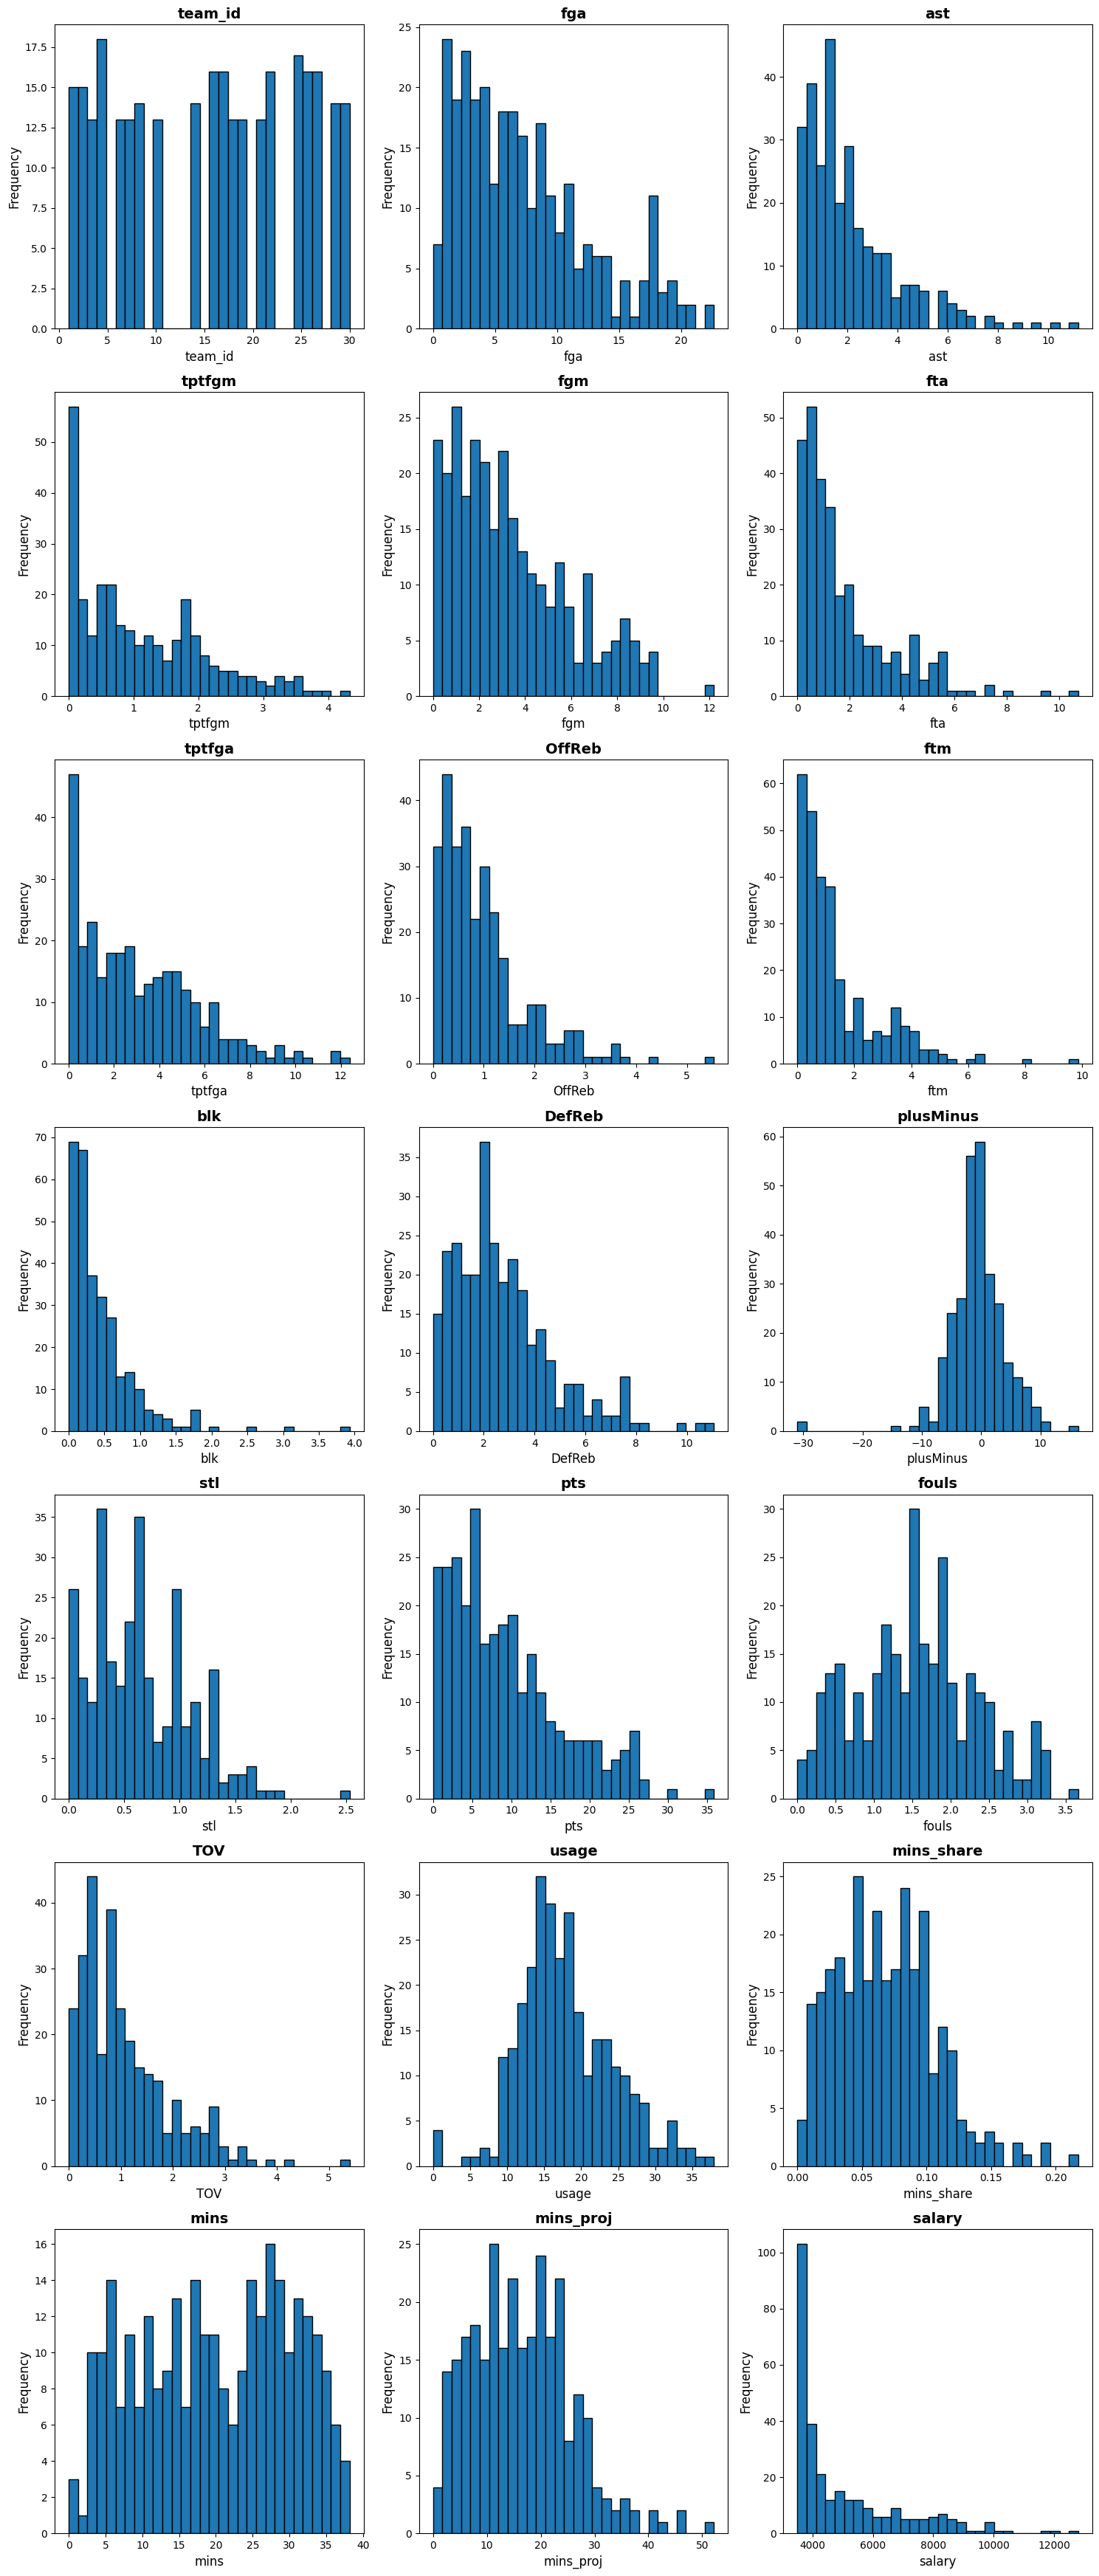

In [47]:
num_features = main_df.select_dtypes(include=['number']).columns
num_cols = 3  # Number of columns in the grid
num_rows = -(-len(num_features) // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figure size dynamically
axes = axes.flatten()  # Flatten the 2D array of subplots for easy indexing

for idx, col_name in enumerate(num_features):
    ax = axes[idx]  # Select the appropriate subplot
    ax.hist(main_df[col_name].dropna(), bins=30, edgecolor='black')

    # Set title and labels with larger font sizes
    ax.set_title(f"{col_name}", fontsize=14, fontweight='bold')
    ax.set_xlabel(col_name, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

# Hide any unused subplots (in case total features are not a multiple of `num_cols`)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [48]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Brook Lopez,20250210_GS@MIL,28006619932,17,MIL,ATL,10.000000,1.866667,1.733333,4.400000,...,32.133333,24.120487,5900,2025-02-10,C,False,False,False,False,True
2,Shake Milton,20250210_UTA@LAL,28008397499,14,LAL,ORL,3.600000,2.266667,0.666667,1.800000,...,14.200000,9.417833,3700,2025-02-10,SG,True,False,False,False,False
3,Gary Trent Jr.,20250210_GS@MIL,28038899869,17,MIL,GS,9.066667,1.666667,3.000000,4.133333,...,25.466667,19.116237,4200,2025-02-10,SG,False,True,True,False,False
4,Gary Payton II,20250210_GS@MIL,28038983399,10,GS,IND,4.333333,1.400000,0.400000,2.333333,...,14.000000,11.332027,3700,2025-02-10,PG,True,True,False,False,False
5,Buddy Hield,20250210_GS@MIL,28038998249,10,GS,GS,9.800000,2.333333,2.200000,3.666667,...,24.933333,20.181801,4900,2025-02-10,SF,True,True,False,False,False


In [49]:
#Writing to csv
main_df.to_csv('ready_for_pred.csv', index = False)